Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
# Блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Простые модели, на которых будем проверять
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Возможный бонус
from sklearn.linear_model import Ridge

# Вспомогательные методы
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import  make_scorer

# буст
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [2]:
# Загрузим наши данные
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


    Сразу очевидно, что не все параметры будут нужны для нашей цели (определение стоимости автомобиля). Например, дата выгрузки анкеты или создания объявления. Также наличие фотографий может влиять на скорость продажи машины, но не на ее рыночную стоимость. Удалим их. Сомнительно, что большую роль сыграет месяц регистрации, но пока оставим, как есть.

In [3]:
del df['DateCrawled'], df['DateCreated'], df['NumberOfPictures'], df['PostalCode'], df['LastSeen']
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [5]:
# Посмотрим инфо по интересующим нас данным
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [6]:
# Посмотрим распределения значений
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


    Видим, что
    1. С типами в целом, всё в порядке
    2. Есть много пропущенный значений. И если для CatBoost это не проблема, то для более простых моделей все равно потребуется обработка
    3. Есть явные выбросы в обе стороны у лошадинных сил и года регистрации. Также нулевой месяц регистрации вызывает вопросы
    
    Начнем с обработки выбросов.

In [7]:
df['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

    Поскольку у нас целых 37000+ нулевых значений, просто так удалять мы их пока не будем (т.к. это грубо 9% всех данных) будем считать 0 отсутствием данных о месяце.

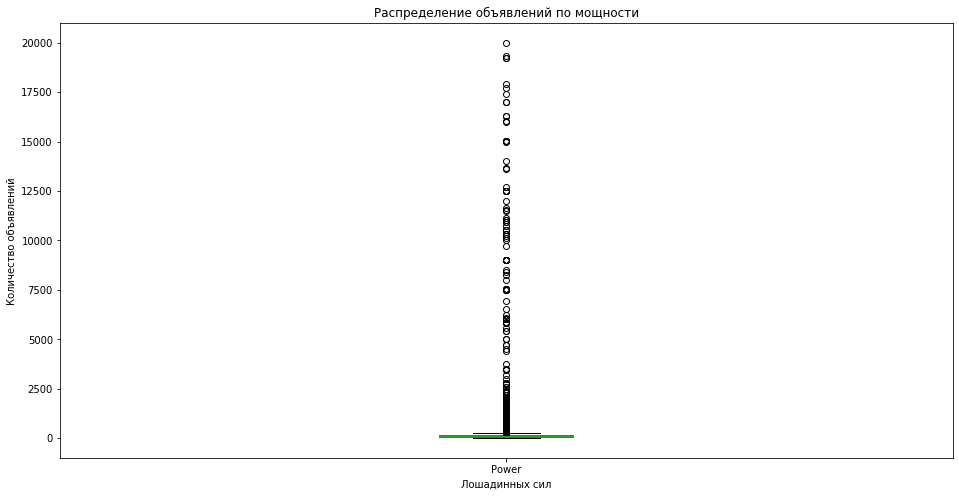

In [8]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение объявлений по мощности')
ax.set_xlabel('Лошадинных сил')
ax.set_ylabel('Количество объявлений')
_, bp = df['Power'].plot(kind='box', figsize=(16,8), ax=ax, return_type='both')

In [9]:
# С помощью гугления было выяснено, что самая большая мощность серийного автомобиля - 2000 лошадинных сил
# тем не менее, посмотрим, какие у нас тут представлены данные

df[df['Power'] > 2000].head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
7661,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN
11039,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no
19092,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no
25232,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no
33952,3740,small,2006,manual,6920,aygo,90000,10,NaN,toyota,no
36206,5400,NaN,2017,manual,2017,transporter,150000,8,gasoline,volkswagen,NaN
44520,2500,convertible,1998,manual,7512,golf,150000,6,NaN,volkswagen,NaN
45053,15800,convertible,2014,auto,10218,fortwo,30000,3,petrol,smart,NaN
45216,1690,sedan,1999,manual,7544,golf,125000,12,petrol,volkswagen,NaN
53158,1200,small,2001,manual,5411,seicento,150000,2,NaN,fiat,no


    Изучив несколько из представленных машин, я понял, что мощность можно исправить только у fiat seicento (выглядит так, что умножили на 100). Где-то в мощности продублирован год, но в остальном выглядит так, что это какие-то случайные значения, поэтому тут мы ничего исправить не можем ориентируясь на них, но можем ориентируясь на остальные данные.
    
    Для начала посмотрим наши границы.
    
    

In [10]:
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]
whiskers[1][1]

254.0

In [11]:
# возьмем за отсечку кайен с его 340 л.с.
df[df['Power'] > 340]['Brand'].count()

1534

In [12]:
# Рассмотрим минимальные значения
df[df['Power'] < whiskers[0][0]]['Power'].value_counts()

0     40225
60    15897
54     5745
50     4627
58     3854
      ...  
21        6
9         5
28        5
32        5
22        5
Name: Power, Length: 69, dtype: int64

    В данном случае 40к+ нулевых значений дают о себе знать. Судя по всему это 40000 неуказанных мощностей. Однако, мощность зачастую зависит от модели и года выпуска, а значит мы можем попробовать заполнить эти данные по уже имеющимся. И если где-то это не получится, рассмотрим вариант удаления этих значений

In [13]:
def calculate_power(df, brand, model, year):
    df_part = df[(df['RegistrationYear'] == year) & (df['Brand'] == brand) & (df['Model'] == model)]
    if (df_part['Power'].count() == 0):
        # если не нашли по году, бренду и модели, пробуем только по бренду + модели
        df_part = df[(df['Brand'] == brand) & (df['Model'] == model)]
    
    median_power = df_part['Power'].median()
    
    if (math.isnan(median_power)):
        median_power = 0
        
    return median_power

# Попробуем заполнить мощность для наших плохих данных
bad_power_df = df[(df['Power'] < 30) | (df['Power'] > 340)][['Brand', 'Model', 'RegistrationYear']]
bad_power_df.count()

Brand               42667
Model               35893
RegistrationYear    42667
dtype: int64

In [14]:
# Заполним незаполненные модели категорией other
bad_power_df['Model'] = bad_power_df['Model'].fillna('other')

In [15]:
bad_power_df = bad_power_df.drop_duplicates()
bad_power_df.count()

Brand               4758
Model               4758
RegistrationYear    4758
dtype: int64

In [16]:
%%time

for row in bad_power_df.itertuples(index=True, name='Pandas'):
    year = getattr(row, "RegistrationYear")
    brand = getattr(row, "Brand")
    model = getattr(row, "Model")
    median = calculate_power(df, brand, model, year)
    searchRow = ((df['Power'] < 30) | (df['Power'] > 340)) & (df['Brand'] == brand) & (df['Model'] == model) & (df['RegistrationYear'] == year)
    df.loc[searchRow, 'Power'] = median

CPU times: user 7min 42s, sys: 272 ms, total: 7min 43s
Wall time: 7min 45s


In [17]:
# Посмотрим, сколько нулевых значений осталось
df[df['Power'] == 0]['Price'].count()

7755

In [18]:
# Остались только какие-то уникальные модели, которые не встретились в остальной выборке, удалим их
df = df[df['Power'] != 0]

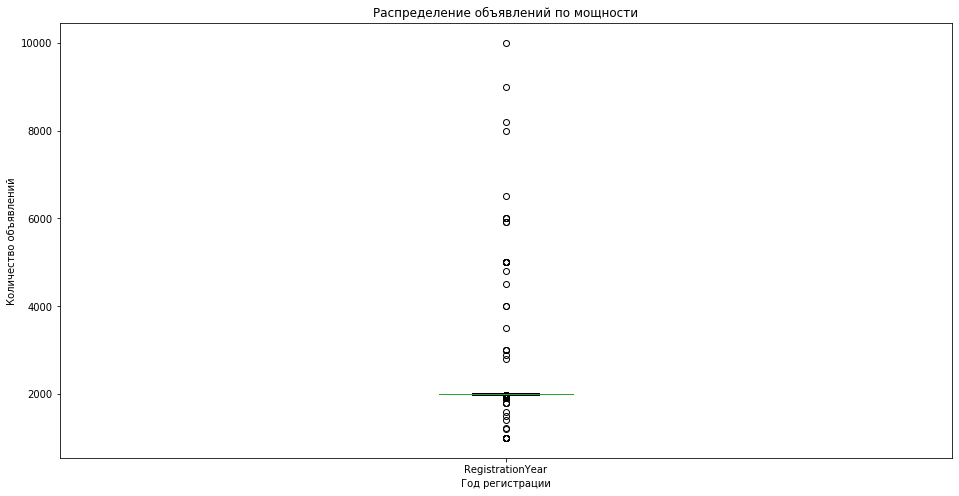

In [19]:
# Разберемся с годами
fig, ax = plt.subplots(1)
ax.set_title('Распределение объявлений по мощности')
ax.set_xlabel('Год регистрации')
ax.set_ylabel('Количество объявлений')
_, bp = df['RegistrationYear'].plot(kind='box', figsize=(16,8), ax=ax, return_type='both')

In [20]:
# Выберем только значения в диапазоне от 2020 года (остальные вряд ли возможны) 
# и от 1980 (меньше также вряд ли возможны и нам интересны)

df[(df['RegistrationYear'] < 1980) | (df['RegistrationYear'] > 2020)]['Price'].count()

2726

In [21]:
# Поскольку восстановить эти данные проблема, удалим их
df = df[(df['RegistrationYear'] >= 1980) | (df['RegistrationYear'] <= 2020)]

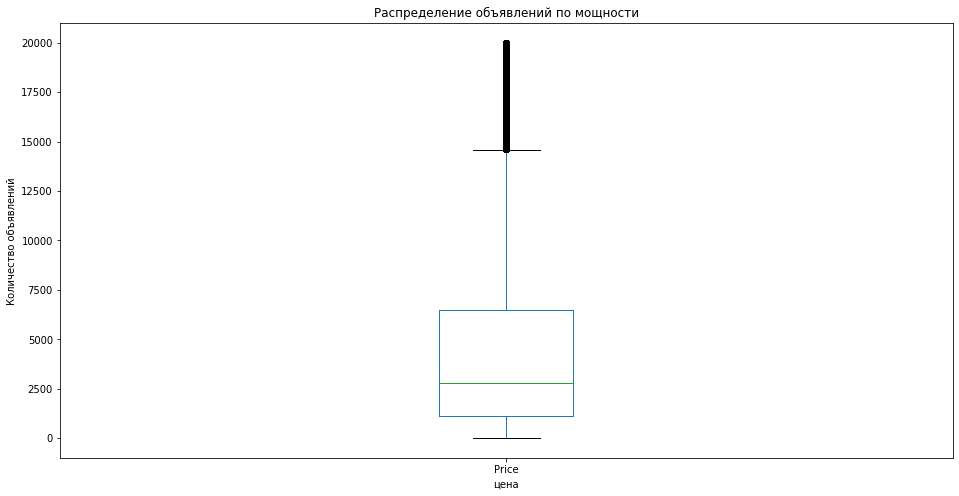

In [22]:
# Посмотрим на boxplot
fig, ax = plt.subplots(1)
ax.set_title('Распределение объявлений по мощности')
ax.set_xlabel('цена')
ax.set_ylabel('Количество объявлений')
_, bp = df['Price'].plot(kind='box', figsize=(16,8), ax=ax, return_type='both')

In [23]:
# Посмотрим, что у нас с ценой (есть нулевые значения)
df[df['Price'] < 10]['Price'].value_counts()

0    9317
1     988
5      23
2       9
9       6
3       5
7       2
8       1
Name: Price, dtype: int64

In [24]:
# По верхней границе находятся в основном audi, bmw и т.д.
# Есть исключения, но выделять их отдельно проблематично, оставим как есть
# А вот нулевые цены представляют реальную проблему, обработаем их по аналогии с мощностью двигателя,
# Но возьмем на этот раз не медиану, а среднее

def calculate_price(df, brand, model, year):
    # в среднем не будем рассчитывать нулевые значения
    df_part = df[(df['Price'] >= 10) & (df['RegistrationYear'] == year) & (df['Brand'] == brand) & (df['Model'] == model)]
    if (df_part['Price'].count() == 0):
        # если не нашли по году, бренду и модели, пробуем только по бренду + модели
        df_part = df[(df['Price'] >= 10) & (df['Brand'] == brand) & (df['Model'] == model)]
    
    mean_price = df_part['Price'].mean()
    
    if (math.isnan(mean_price)):
        mean_price = 0
        
    return mean_price

# Попробуем заполнить мощность для наших плохих данных
bad_price_df = df[df['Price'] < 10][['Brand', 'Model', 'RegistrationYear']]
bad_price_df['Model'] = bad_price_df['Model'].fillna('other')
bad_price_df = bad_price_df.drop_duplicates()
bad_price_df.count()

Brand               2379
Model               2379
RegistrationYear    2379
dtype: int64

In [25]:
%%time

for row in bad_price_df.itertuples(index=True, name='Pandas'):
    year = getattr(row, "RegistrationYear")
    brand = getattr(row, "Brand")
    model = getattr(row, "Model")
    mean_price = calculate_price(df, brand, model, year)
    searchRow = (df['Price'] < 15) & (df['Brand'] == brand) & (df['Model'] == model) & (df['RegistrationYear'] == year)
    df.loc[searchRow, 'Price'] = mean_price
    
df[df['Price'] < 10]['Price'].count()

CPU times: user 3min 48s, sys: 276 ms, total: 3min 48s
Wall time: 3min 50s


1003

In [26]:
# Осталось совсем немного кривых данных, удалим их
df = df[df['Price'] >= 10]

### Промежуточный вывод

    1. Мы дозаполнили данные о мощности автомобиля для отсутствующих значений и выбросов
    2. Где не получилось этого сделать, мы удалили данные с незаполненным годом регистрации и мощностью автомобиля, т.к. это факторы, которые в любом случае будут влиять на цену
    3. Мы заполнили отсутствующие значения для цены, не затрагивая верхнюю границу
    
    Километраж выглядит похожим на правду, а месяц мы вряд ли сможем как-то спрогнозировать, поэтому оставляем, как есть.
    
    В остальном, нам необходимо заполнить пропуски в категориальных признаках.
    
    Важный момент, дубликаты обрабатывать не будем, т.к. в случае продажи машин могут продаваться с разным цветом и объявления просто похожи друг на друга.

In [27]:
# Посмотрим, как обстоят дела с пропуске в обработанном DF
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345611 entries, 0 to 354368
Data columns (total 11 columns):
Price                345611 non-null float64
VehicleType          313073 non-null object
RegistrationYear     345611 non-null int64
Gearbox              329835 non-null object
Power                345611 non-null float64
Model                333203 non-null object
Kilometer            345611 non-null int64
RegistrationMonth    345611 non-null int64
FuelType             317205 non-null object
Brand                345611 non-null object
NotRepaired          280176 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 31.6+ MB


    Итак, по сути у нас остались необработанными следующие признаки:
    1. VehicleType
    2. Gearbox
    3. Model
    4. FuelType
    5. NotRepaired

In [28]:
# Посмотрим, есть ли артифакты в значениях NotRepaired
df['NotRepaired'].value_counts()

no     245045
yes     35131
Name: NotRepaired, dtype: int64

In [29]:
# По сути, мы имеем третью категорию, когда нам неизвестно была ли машина в ремонте. Выгоднее это указывать,
# если ремонт все же был, однако нам неизвестен источник данных и, возможно, мы просто не смогли подтянуть соответствующую
# информацию, поэтому в данном случае будет правильно переделать признак в числовой для удобства, где
# 0 будет отсутствие ремонта, 1 неизвестно и 2 - ремонт был (таким образом определим вес каждой категории)

df['NotRepaired'] = df['NotRepaired'].fillna(1)

def fill_not_repaired(value):
    if value == 'no':
        return 0
    elif value == 'yes':
        return 2
    else:
        return value

df['NotRepaired'] = df['NotRepaired'].apply(fill_not_repaired)
df['NotRepaired'].value_counts()

0    245045
1     65435
2     35131
Name: NotRepaired, dtype: int64

In [30]:
# Разберемся с VehicleType
df['VehicleType'].value_counts()

sedan          90483
small          78828
wagon          64565
bus            28469
convertible    19974
coupe          15914
suv            11798
other           3042
Name: VehicleType, dtype: int64

In [31]:
# Тут на самом деле отсутствие значения можно выделить в отдельную категорию
df['VehicleType'] = df['VehicleType'].fillna('undefined')

In [32]:
# Аналогичным образом поступим и для остальных признаков
# т.к. их восстановление или проблематично или не имеет решающей роли, в т.ч. т.к. их осталось меньше 10%
df['Gearbox'] = df['Gearbox'].fillna('undefined')
df['Model'] = df['Model'].fillna('undefined')
df['FuelType'] = df['FuelType'].fillna('undefined')
df['Brand'] = df['Brand'].fillna('undefined')

# сразу сбросим индексы
df = df.reset_index()

# посмотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345611 entries, 0 to 345610
Data columns (total 12 columns):
index                345611 non-null int64
Price                345611 non-null float64
VehicleType          345611 non-null object
RegistrationYear     345611 non-null int64
Gearbox              345611 non-null object
Power                345611 non-null float64
Model                345611 non-null object
Kilometer            345611 non-null int64
RegistrationMonth    345611 non-null int64
FuelType             345611 non-null object
Brand                345611 non-null object
NotRepaired          345611 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 31.6+ MB


In [33]:
# Удалим уже не нужные DF
del bad_price_df, bad_power_df

### Вывод

    Мы отлично подготовили данные, попытавшись спасти максимум возможного. Не забыли обработать аномальные значения, рассмотрели каждый признак и исключили признаки, не имеющие для нас значения.

# 2. Обучение моделей

    Поступим следующим образом:

    1. Сперва отскалируем признаки и подготовим их для обучения  для простых моделей
    2. Разобьем выборку на тестовую и валидационную
    3. Обучим наши модели на простых моделях (линейная регрессия и случайный лес)
    4. Попробуем LGBMRegressor и CatBoostRegressor

In [34]:
# Определим random_state
RANDOM_STATE=12345

In [35]:
# выделим категориальные признаки
# не забудем, что хоть речь и о числовом представлении, на самом деле месяц регистрации - это категория
# однако т.к. выше мы обработали признак NotRepaired и фактически задали состояниям веса, его сюда не добавляем
category_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'RegistrationMonth']

# Также определим числовые признаки
number_features = ['RegistrationYear', 'Power', 'Kilometer', 'NotRepaired']

# Оставим в DF только то, что нужно (с обработкой категориальных признаков)
df = df[number_features + category_features + ['Price']];
df_simple = df.copy()
df_simple.head()

,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType,Gearbox,Brand,Model,FuelType,RegistrationMonth,Price
0,1993,75.0,150000,1,undefined,manual,volkswagen,golf,petrol,0,480.0
1,2011,190.0,125000,2,coupe,manual,audi,undefined,gasoline,5,18300.0
2,2004,163.0,125000,1,suv,auto,jeep,grand,gasoline,8,9800.0
3,2001,75.0,150000,0,small,manual,volkswagen,golf,petrol,6,1500.0
4,2008,69.0,90000,0,small,manual,skoda,fabia,gasoline,7,3600.0


In [36]:
# Разделим признаки
features = df_simple.drop(columns='Price')
target = df_simple['Price']

# Подготовим наши категориальные признаки, будем использовать технику OHE, как более универсальную
features_ohe = pd.get_dummies(features, columns=category_features, drop_first=True)
features_ohe.head()

,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,RegistrationMonth_3,RegistrationMonth_4,RegistrationMonth_5,RegistrationMonth_6,RegistrationMonth_7,RegistrationMonth_8,RegistrationMonth_9,RegistrationMonth_10,RegistrationMonth_11,RegistrationMonth_12
0,1993,75.0,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011,190.0,125000,2,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2004,163.0,125000,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,2001,75.0,150000,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2008,69.0,90000,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [37]:
# Проведем скалирование числовых признаков
scaler = StandardScaler()

scaler.fit(features_ohe[number_features])
features_ohe_scaled = features_ohe.copy()
features_ohe_scaled[number_features] = scaler.transform(features_ohe_scaled[number_features])
features_ohe_scaled.head()

,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,RegistrationMonth_3,RegistrationMonth_4,RegistrationMonth_5,RegistrationMonth_6,RegistrationMonth_7,RegistrationMonth_8,RegistrationMonth_9,RegistrationMonth_10,RegistrationMonth_11,RegistrationMonth_12
0,-0.302286,-0.552358,0.573469,0.913810,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.219669,0.921605,-0.099604,2.418345,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.016686,0.575544,-0.099604,0.913810,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,-0.070306,-0.552358,0.573469,-0.590724,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.132676,-0.629260,-1.041906,-0.590724,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [38]:
# Поделим нашу выборку в пропорции 75-25, т.к. параметры мы будем искать с помощью кросс-валидации через GridSearchCV
# Соответственно, валидационная выборка в контексте задачи нам не пригодится
# Вторая функция оставлена на всякий случай, т.к. изначально делал 3 выборки в рамках работы 
# (предполагал, что мы будем перепроверять итоговую модель на тесте, но решил, что это избыточно в рамках нашей задачи)

def create_train_valid_and_test_set(features, target):
    features_train, df_valid_ant_test_features, target_train, df_valid_ant_test_target = train_test_split(
        features, target, test_size=0.4, random_state=RANDOM_STATE)

    # теперь разделим тестовую выборку от валидационной
    features_valid, features_test, target_valid, target_test = train_test_split(
        df_valid_ant_test_features, df_valid_ant_test_target, test_size=0.5, random_state=RANDOM_STATE)

    del df_valid_ant_test_features, df_valid_ant_test_target
    
    # Проверим, что получилось
    print('Target test count = {}, Valid count = {}, Train test count = {}'.format(target_test.count(), target_valid.count(), target_train.count()))
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

def create_train_and_test_set(features, target):
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)
    
    # Проверим, что получилось
    print('Target test count = {}, Train test count = {}'.format(target_test.count(), target_train.count()))
    
    return features_train, target_train, features_test, target_test

features_train, target_train, features_test, target_test = create_train_and_test_set(features_ohe_scaled, target)

Target test count = 86403, Train test count = 259208


In [39]:
# Определим функцию для подсчета RMSE
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

## Простые модели

    Опробуем линейную регрессию и случайный лес

### Случайный лес

### Небольшая ремарка 

Я понимаю, что параметры для случайного леса скорее "детские" и стоило бы взять совершенно другие числа. Но проблема в том, что как я не изголялся, в последние дни юпитер зависает и очень долго это все учит (было ждал несколько часов на вполне средних параметрах и не дождался)

Как вариант, можно было избавиться от OHE и использовать OrdinalEncoder, но вроде это не сильно хороший вариант для линейных моделей т.к. создает вес категориальных признаков, даже если этого веса быть не должно.

В связи с этим было принято решение все же оставить OHE и случайный лес, но попробовать уменьшить параметры.

In [40]:
%%time

# Попробуем обучить случайный лес
parameters = {'n_estimators': range(5,11,5),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)

grid.best_params_

# Чтобы не пересчитывать получившиеся параметры при доработках:
# {'max_depth': 7,
#  'min_samples_leaf': 3,
#  'min_samples_split': 2,
#  'n_estimators': 10}

CPU times: user 11min 34s, sys: 21.9 s, total: 11min 56s
Wall time: 11min 59s


{'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 10}

In [41]:
# Чтобы не собирать вручную результаты, напишем класс, который будет сохранять время обучения, время предсказания и RMSE

import time

class ModelHelper:
    def __init__(self, name, model):
        """Constructor"""
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
    
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [42]:
# Создадим переменную, где будут храниться результаты
    
result = []

In [43]:
# И создадим функцию для вывода по красоте
def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(info[0], info[1], info[2], info[3]))

In [44]:
# Проверим наш случайный лес
model_forest = RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=10, random_state=RANDOM_STATE)
model_forest_helper = ModelHelper('Random forest', model_forest)
model_forest_helper.fit(features_train, target_train)
model_forest_helper.predict(features_test, target_test)
result.append(model_forest_helper.getResult())

### Линейная регрессия

In [45]:
# Попробуем линейную регрессию
model_lr = LinearRegression()
model_lr_helper = ModelHelper('Linear regression', model_lr)
model_lr_helper.fit(features_train, target_train)
model_lr_helper.predict(features_test, target_test)
result.append(model_lr_helper.getResult())

In [46]:
# Посмотрим на промежуточный результат
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|          32.19294|           0.21924|  2141.50120|
|   Linear regression|          27.83889|           0.23438|  3015.38254|


## Библиотеки для градиентного бустинга

### Небольшая ремарка

Фактически, CatBoost будет использовать OHE при передаче категориальных признаков. Это означает, что мы могли бы воспользоваться уже имеющимися features и target (т.к. именно так мы их и обработали). Однако, LightGBM использует какой-то другой свой алгоритм, который, в теории, может быть быстрее. Однако, он не переваривает строки в категориальных признаках.

Раз уж мы сравниваем две разные библиотеки, будет правильно создать им равные возможности и посмотреть на что они способны без нашей помощи. А значит, мы проведем дополнительную работу и сделаем следующим образом:
    1. Возьмем наш итоговый обработанный датасет
    2. Отскалируем снова числовые признаки
    3. А вот категориальные признаки для LightGBM будем готовить с помощью OrdinalEncoding
    4. Для CatBoost ничего готовить не будем и передадим категориальные признаки, как есть
И посмотрим, что получится.

In [47]:
pd.options.mode.chained_assignment = None

# Подготовим заново признаки для бустинга
features = df.drop(columns='Price')
target = df['Price']

# Разделим выборку на обучающую и тестовую
features_train, target_train, features_test, target_test = create_train_and_test_set(features, target)

# Проведем скалирование
scaler = StandardScaler()
scaler.fit(features_train[number_features])
features_train[number_features] = scaler.transform(features_train[number_features])
features_test[number_features] = scaler.transform(features_test[number_features])

features_train.head()

Target test count = 86403, Train test count = 259208


,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType,Gearbox,Brand,Model,FuelType,RegistrationMonth
123827,0.076771,0.086226,-0.097278,-0.589330,convertible,manual,opel,tigra,petrol,4
298912,0.106313,0.161521,0.575242,-0.589330,bus,manual,renault,other,gasoline,8
158804,-0.159572,-0.541236,0.575242,0.916605,convertible,manual,volkswagen,golf,petrol,3
65006,-0.159572,0.927025,-0.097278,-0.589330,convertible,manual,mercedes_benz,slk,petrol,1
287084,-0.189115,0.086226,0.575242,-0.589330,coupe,auto,honda,cr_reihe,petrol,7


In [48]:
# Для GBM дополнительно обработаем категориальные признаки

features_train_gbm = features_train.copy()
features_test_gbm = features_test.copy()
# Месяц регистрации преобразовывать не нужно
category_features_gbm = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType']

encoder = OrdinalEncoder()
encoder.fit(features_train_gbm[category_features_gbm])
features_train_gbm[category_features_gbm] = encoder.transform(features_train_gbm[category_features_gbm])
features_test_gbm[category_features_gbm] = encoder.transform(features_test_gbm[category_features_gbm])

features_train_gbm.head()

,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType,Gearbox,Brand,Model,FuelType,RegistrationMonth
123827,0.076771,0.086226,-0.097278,-0.589330,1.0,1.0,24.0,217.0,6.0,4
298912,0.106313,0.161521,0.575242,-0.589330,0.0,1.0,27.0,166.0,2.0,8
158804,-0.159572,-0.541236,0.575242,0.916605,1.0,1.0,38.0,116.0,6.0,3
65006,-0.159572,0.927025,-0.097278,-0.589330,1.0,1.0,20.0,207.0,6.0,1
287084,-0.189115,0.086226,0.575242,-0.589330,2.0,0.0,11.0,84.0,6.0,7


### LightGBM

In [49]:
%%time

gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=RANDOM_STATE)
gbm_params = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 61, 20), 'num_leaves': range(20, 41, 10)}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=3, scoring='neg_mean_squared_error')
grid_gbm.fit(features_train_gbm, target_train);

grid_gbm.best_params_

# Для отладки - {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 41}

CPU times: user 3min 10s, sys: 1.19 s, total: 3min 11s
Wall time: 3min 13s


{'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 30}

In [50]:
# Посмотрим, что получилось в итоге
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(features_train_gbm, target_train)
model_gbm_helper.predict(features_test_gbm, target_test)
result.append(model_gbm_helper.getResult())

### CatBoost

In [51]:
%%time

cbr = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=category_features, random_seed=RANDOM_STATE)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train, target_train);

grid_cbr.best_params_

#  Для отладки: {'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

CPU times: user 15min 30s, sys: 1min 17s, total: 16min 48s
Wall time: 18min 37s


{'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

In [52]:
# Посмотрим, что получилось в итоге
model_cbr = grid_cbr.best_estimator_
model_cbr_helper = ModelHelper('CatBoost', model_cbr)
model_cbr_helper.fit(features_train, target_train)
model_cbr_helper.predict(features_test, target_test)
result.append(model_cbr_helper.getResult())

# 3. Анализ моделей

In [53]:
# Посмотрим, что в итоге получилось
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|          32.19294|           0.21924|  2141.50120|
|   Linear regression|          27.83889|           0.23438|  3015.38254|
|            LightGBM|           4.19900|           0.49037|  1764.53452|
|            CatBoost|          25.56402|           0.27835|  1705.42145|


# Общий вывод

Подведем итоги. Исходя из условий задачи, заказчику важны:
    1. качество предсказания;
    2. скорость предсказания;
    3. время обучения.

Исходя из того, что порядок криттериев также учитывает их приоритет, следует отдать предпочтение CatBoost, т.к. она имеет лучшее качество предсказания (хотя и недалеко ушло от LightGBM). Однако существенно выигрывает в скорости предсказания. LightGBM тем не менее показывет лучшие результаты во времени обучения и почти не отстает в качестве. Поэтому если время обучения все же не менее критично, чем скорость предсказания, стоит отдать предпочтение ей.

Линейные же модели обладают лучше скоростью предсказания, но плохим качеством и очень долго учатся, а значит не подходят для нашей задачи.



